# Multilayer Neural Network

A multilayer neural network is multilayer of perceptrons. It consists an input layer, several hidden layers, output layer, fully connected weights and non-linear activation function.

## 1. Algorithm

### Multilayer Neural Network

First, a multilayer neural network has a non-linear activation function in most cases, and sigmoid ($\sigma(\cdot)$), hyperbolic tangent ($tanh(\cdot)$) and rectified linear ($RELU(\cdot)$) activation functions are widely used. $$ \sigma(x) = \frac{1}{1 + e^{-x}} $$

$$ tanh(x) = \frac{e^x-e^{-x}}{e^x+e^{-x}} $$$$ RELU(x) = \begin{cases} x & \text{if}\ x > 0,\\0 & \text{otherwise}\end{cases} $$
Further, a MLP consists of many layers (an input and an output layer with one or more hidden layers) of non-linear activating nodes. Since MLPs are fully connected, each node in one layer connects with a certain weight to every node in the following layer.

Learning occurs in MLP by changing connection weights after each piece of data is processed, based on the amount of error in the output compared to the expected result. This is a supervised learning, and is carried out through backpropagation, a generalization of the least mean squares algorithm in the linear perceptron.

The basic idea of backpropagation is to take advantage of the Chain Rule to derive derivative of each layers, from end to start.

Error in an output node $j$ in the $n$ th training example by $e_j(n)=d_j(n)-y_j(n)$, where $d$ is the target value and $y$ is the value produced by the perceptron. The node weights can be adjusted by minimizing the sum square error in the entire output, given by

$$\mathcal{E}(n)=\frac{1}{2}\sum_j e_j^2(n)$$
Using gradient descent, the change in each weight of output layer is

$$\Delta w_{ji} (n) = -\gamma\frac{\partial\mathcal{E}(n)}{\partial v_j(n)} y_i(n)$$
where $y_i$ is the output of the previous neuron, $\gamma$ is the learning rate, $v_j$ is the output of output layer.

It is easy to prove that for an output node this derivative can be simplified to

$$-\frac{\partial\mathcal{E}(n)}{\partial v_j(n)} = e_j(n)\phi^\prime (v_j(n))$$
where $\phi^\prime$ is the derivative of the activation function described above, which itself does not vary. For hidden nodes, it can be shown that the relevant derivative is

$$-\frac{\partial\mathcal{E}(n)}{\partial v_j(n)} = \phi^\prime (v_j(n))\sum_k -\frac{\partial\mathcal{E}(n)}{\partial v_k(n)} w_{kj}(n)$$

### Batch Gradient Descent

Batch gradient descent just take all the training data in every step of gradient descent, so it's just the basic form of gradient descent descussed in the Gradient Descent ssection.

### Stochastic Gradient Descent

Stochastic Gradient Descent (SGD) considers one random sample in every step. As only one sample is used, the loss will not necessarily decrease. But the loss will decrease in a long training period. SGD generally converges faster when the dataset is large as it causes updates to the parameters more frequently.

## 2. Code

In [8]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn import datasets
from sklearn.model_selection import train_test_split
from keras.datasets import fashion_mnist

from sklearn.metrics import accuracy_score
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
import seaborn as sns

In [24]:
class MultilayerPerceptron():
  
    def __init__(self, layers = [784, 60, 60, 10], actFun_type='relu'):
        self.actFun_type = actFun_type
        self.layers = layers
        self.L = len(self.layers)
        self.W =[[0.0]]
        self.B = [[0.0]]
        for i in range(1, self.L):
            w_temp = np.random.randn(self.layers[i], self.layers[i-1]) * np.sqrt(2/self.layers[i-1])
            b_temp = np.random.randn(self.layers[i], 1) * np.sqrt(2/self.layers[i-1])

            self.W.append(w_temp)
            self.B.append(b_temp)

    def reset_weights(self, layers = [784, 60, 60, 10]):
        self.layers = layers
        self.L = len(self.layers)
        self.W = [[0.0]]
        self.B = [[0.0]]
        for i in range(1, self.L):
            w_temp = np.random.randn(self.layers[i], self.layers[i-1])*np.sqrt(2/self.layers[i-1])
            b_temp = np.random.randn(self.layers[i], 1)*np.sqrt(2/self.layers[i-1])

            self.W.append(w_temp)
            self.B.append(b_temp)

    def forward_pass(self, p, predict_vector = False):
        Z =[[0.0]]
        A = [p[0]]
        for i in range(1, self.L):
            z = (self.W[i] @ A[i-1]) + self.B[i]
            a = self.actFun(z, self.actFun_type)
            Z.append(z)
            A.append(a)

        if predict_vector == True:
            return A[-1]
        else:
            return Z, A

    def mse(self, a, y):
        return .5*sum((a[i]-y[i])**2 for i in range(10))[0]

    def MSE(self, data):
        c = 0.0
        for p in data:
            a = self.forward_pass(p, predict_vector=True)
            c += self.mse(a, p[1])
        return c/len(data)

    def actFun(self, z, type):
        if type == 'tanh':
            return np.tanh(z)
        elif type == 'sigmoid':
            return 1.0 / (1.0 + np.exp(-z))
        elif type == 'relu':
            return np.maximum(0, z)
        else:
            return None

    def diff_actFun(self, z, type):
        if type == 'tanh':
            return 1.0 - (np.tanh(z))**2
        elif type == 'sigmoid':
            return self.actFun(z, type) * (1-self.actFun(z, type))
        elif type == 'relu':
            return np.where(z > 0, 1.0, 0)
        else:
            return None

    def deltas_dict(self, p):
        Z, A = self.forward_pass(p)
        deltas = dict()
        deltas[self.L-1] = (A[-1] - p[1])*self.diff_actFun(Z[-1], self.actFun_type)
        for l in range(self.L-2, 0, -1):
            deltas[l] = (self.W[l+1].T @ deltas[l+1]) *self.diff_actFun(Z[l], self.actFun_type)

        return A, deltas

    def stochastic_gradient_descent(self, data, alpha = 0.04, epochs = 3):
        print("Initial Cost = {}".format(self.MSE(data)))
        for k in range(epochs):
            for p in data:
                A, deltas = self.deltas_dict(p)
                for i in range(1, self.L):
                    self.W[i] = self.W[i] - alpha*deltas[i]@A[i-1].T
                    self.B[i] = self.B[i] - alpha*deltas[i]
        print('{0},{1},{2}'.format(k,'cost=',self.MSE(data)))


    def mini_batch_gradient_descent(self, data, batch_size = 15, alpha = 0.04, epochs = 3):
        print("Initial Cost = {}".format(self.MSE(data)))
        data_length = len(data)
        for k in range(epochs):
            for j in range(0, data_length-batch_size, batch_size):
                delta_list = []
                A_list = []
                for p in data[j:j+batch_size]:
                    A, deltas = self.deltas_dict(p)
                    delta_list.append(deltas)
                    A_list.append(A)

                for i in range(1, self.L):
                    self.W[i] = self.W[i] - (alpha/batch_size)*sum(da[0][i]@da[1][i-1].T for da in zip(delta_list, A_list))
                    self.B[i] = self.B[i] - (alpha/batch_size)*sum(deltas[i] for deltas in delta_list)
            print('{0},{1},{2}'.format(k,'cost=',self.MSE(data)))

## 3. Applications on data sets

Fashion MNIST data set

The Fashion MNIST data set is from keras. The dataset has 60,000 training data with 28x28 grayscale images and 10,000 test images. Images are labeled over 10 categories. The pixel depth allows 255 different intensities, with 0 being black and 255 being white. And the classes are: T-shirt/top, Trouser, Pullover, Dress, Coat, Sandal, Shirt, Sneaker, Bag, and Ankle boot with labels 0 to 9 respectively.



Load data set. and split the dataset into train data and test data

In [25]:
(train_X, train_y), (test_X, test_y) = fashion_mnist.load_data()

4423680/4422102 [==============================] - 1s 0us/step


Visualize the first image by putting the pixel together, and it is an Ankle boot.

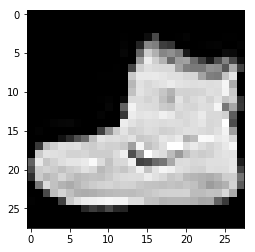

In [26]:
plt.imshow(train_X[0], cmap="gray")
plt.show()

Scale images to $[0, 1]$

In [27]:
train_X = train_X/255
test_X = test_X/255

Flatten images from matrix to a vector.

In [28]:
train_X[0].flatten().reshape(28*28, 1).shape

(784, 1)

Now we are ready to flatten the X matrix. Make a list first and then store the flatten vetors into it. And we also make the y to one hot encoded label vectors; we make a list and store the vectors into it.

In [29]:
X = []
for x in train_X:
    X.append(x.flatten().reshape(28*28, 1))

# Y will temp store one-hot encoded label vectors
Y = []
for y in train_y:
    temp_vec = np.zeros((10, 1))
    temp_vec[y][0] = 1.0
    Y.append(temp_vec)

# Our data will be stored as a list of tuples. 
train_data = [p for p in zip(X, Y)]

# the same method to deal with test data
X = []
for x in test_X:
  X.append(x.flatten().reshape(784, 1))

Y = []
for y in test_y:
    temp_vec = np.zeros((10, 1))
    temp_vec[y][0] = 1.0
    Y.append(temp_vec)

test_data = [p for p in zip(X, Y)]

Now let's train MLP's using sigmoid, hyperbolic tangent, and rectified linear activation functions by mini batch gradient descent, and compare their performances.

In [31]:
net_tanh = MultilayerPerceptron(layers=[784, 60, 60, 10], actFun_type='tanh')
net_tanh.mini_batch_gradient_descent(train_data, batch_size = 16, alpha = 0.01, epochs = 5)

Initial Cost = 1.8186099879304232
0,cost=,0.17496766669041433
1,cost=,0.15447443161922786
2,cost=,0.14390902188288393
3,cost=,0.1368800556914998
4,cost=,0.13158901723811592


In [32]:
net_tanh.MSE(test_data)

0.13900711383494496

In [33]:
net_relu = MultilayerPerceptron(layers=[784, 100, 100, 10], actFun_type='relu')
net_relu.mini_batch_gradient_descent(train_data, batch_size = 16, alpha = 0.01, epochs = 5)

Initial Cost = 0.6492143747437975
0,cost=,0.2513343006324802
1,cost=,0.23909405254875646
2,cost=,0.23300313583815424
3,cost=,0.22862753941621047
4,cost=,0.22582816918154586


In [34]:
net_relu.MSE(test_data)

0.23400720081777213

In [ ]:
net_sig = MultilayerPerceptron(layers=[784, 100, 100, 10], actFun_type='sigmoid')
net_sig.mini_batch_gradient_descent(train_data, batch_size = 16, alpha = 0.01, epochs = 5)

Initial Cost = 1.478722720766633
0,cost=,0.4349701868948273
1,cost=,0.40595944945621815
2,cost=,0.3650028163970172
3,cost=,0.3298019630822553


In [ ]:
net_sig.MSE(test_data)

Comparing three kinds of activation functions while keeping all other hyper-parameters unchanged, sigmoid activation function has the best perfomance on the test data.